In [1]:
import numpy as np
import scipy.signal as sig
import scipy.io
import os
import librosa
import sys
from IPython.display import display, Audio
import time
import pickle

import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', size=10)
plt.rc('font', family='serif')
plt.rc('lines', linewidth = .5)
cm = 2.54
# setting path
sys.path.append("../")
from Utils.dB import *
from HN_decomposition.Subspace.ESPRIT_numpy import *
from HN_decomposition.Subspace.preprocessing_numpy import *

def RMS(x):
        return np.std(x)

figsize = (8.5/cm, 6/cm)

def normalize(input_array, value = 1):
        return input_array/np.amax(np.abs(input_array))*value

In [2]:
## Base params

dpi = 300
cmap = 'gray_r'

## ESTER Criterion

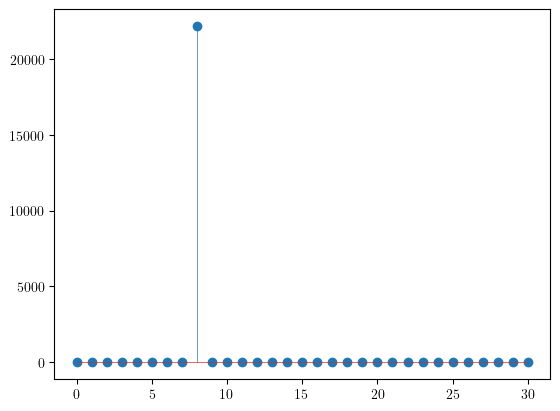

In [3]:
amps_nus = [[1, .1], [1, .2], [1, .4], [.9, .04]]

amp_noise = .1
length_smp = 512

x = np.zeros(length_smp, dtype= np.complex128)

for amp_nu in amps_nus:
    amp = amp_nu[0]
    nu = amp_nu[1]
    x += amp*np.sin(2*np.pi*nu*np.arange(length_smp))

x += amp_noise*np.random.randn(length_smp)


_, J_list = ESTER(
    x=x,
    start_idx = 15,
    window_length = 256,
    max_poles = 30,
    factor = 10
)

plt.stem(J_list)
plt.show()

## Loading the audio file

..\..\Mesures\Mesures_2023.01.27_LAM\Medium_1\Corde_Acier\C_3_P_3_1.mat
dict_keys(['__header__', '__version__', '__globals__', 'FRF', 'acc_t', 'fen_acc', 'fen_mar', 'freq', 'fs', 'mar_t', 'None', 'signal_accelero_fen', 'signal_marteau_fen', 'time', '__function_workspace__'])
sample rate : 51200 Hz


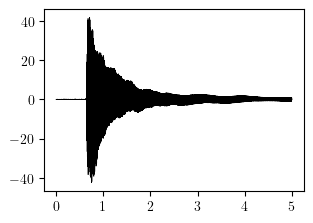

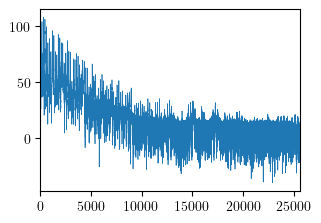

In [4]:
start_sec = .82
length_sec = 4

start_sec = 0
length_sec = 5

fileName = os.path.join('..', '..', 'Mesures', 'Mesures_2023.01.27_LAM', 'Medium_1', 'Corde_Acier', 'C_3_P_3_1.mat')
print(fileName)
data = scipy.io.loadmat(fileName)
print(data.keys())

sr_hz_old =  data['fs'][0,0]
x = data['acc_t'][int(sr_hz_old*start_sec):int(sr_hz_old*(start_sec+length_sec)),0].T
t = np.arange(len(x))/sr_hz_old

print(f'sample rate : {sr_hz_old} Hz')

plt.figure(figsize = figsize)
plt.plot(t,x,'k', linewidth = .5)
plt.show()

plt.figure(figsize = figsize)
plt.plot(np.fft.rfftfreq(len(x), 1/sr_hz_old), dB20(np.fft.rfft(x)))
#plt.semilogx()
plt.xlim(0, sr_hz_old/2)
plt.show()

## Resampling

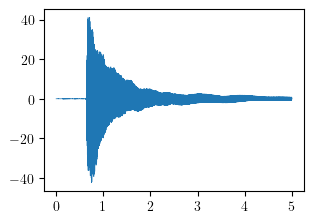

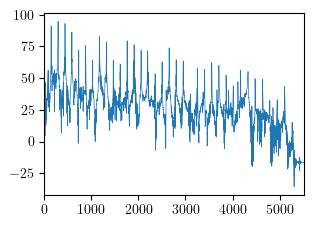

In [5]:
sr_hz = 22050/2
x = librosa.resample(x, orig_sr = sr_hz_old, target_sr = sr_hz)
t = np.arange(len(x))/sr_hz
plt.figure(figsize = figsize)
plt.plot(t,x)
plt.show()
plt.figure(figsize = figsize)
plt.plot(np.fft.rfftfreq(len(x), 1/sr_hz), dB20(np.fft.rfft(x)))
plt.xlim(0, sr_hz/2)
plt.show()

In [6]:
save_folder = os.path.join("..", "..", "PAM_overleaf", "Notes", "HR", "Partials_Tracking", "Figures")

## Harmonic+Noise Decomposition

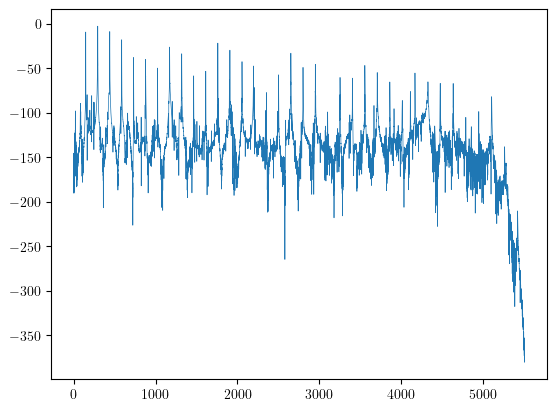

8


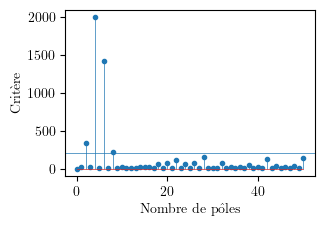

In [61]:
start_idx = np.argmax(np.abs(sig.hilbert(x)))
factor = 10

## Computations
xWhitened, ARFilter = whiten_signal(
    x = x,
    n_fft = 512,
    rankFilter_bins = 200,
    rankFilter_rank = .3,
    ARFilter_length = 18,
)

num_poles, J_list = ESTER(
    x = xWhitened,
    start_idx=start_idx,
    window_length=512,
    max_poles = 50,
    factor = factor
)

f, xWhitened_perio = sig.periodogram(xWhitened, fs = sr_hz, window = 'hann')
plt.plot(f, dB20(xWhitened_perio))
plt.show()

print(num_poles)
plt.figure(figsize=figsize)
markerline, stemline, baseline = plt.stem(J_list)
plt.setp(markerline, markersize = 3)
plt.axhline(np.amax(J_list)/factor)
plt.xlabel('Nombre de pôles')
plt.ylabel('Critère')
plt.tight_layout()
plt.savefig('ESTER.pdf')
plt.show()

Overlap add condition : True
Signal Order : 50


c:\Users\pelad\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\lib\display.py:172: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.array(data, dtype=float)


c:\Users\pelad\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\axes\_axes.py:7726: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


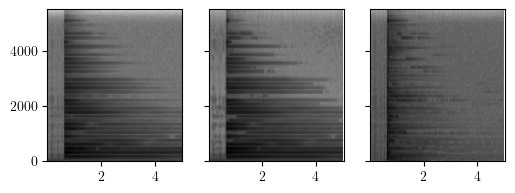

In [8]:
##Parameters
window_length = 1024
hop_length = window_length//4

ester_factor = 50
max_poles = 400
window_type = 'hann'

## Checking Overlap Add Condition
#window = sig.get_window(window_type, window_length)
OLA_condition = sig.check_COLA(
    window = window_type,
    nperseg = window_length,
    noverlap = window_length-hop_length
)
print(f"Overlap add condition : {OLA_condition}")

## Computations
xWhitened, ARFilter = whiten_signal(
    x = x,
    n_fft = 512,
    rankFilter_bins = 200,
    rankFilter_rank = .3,
    ARFilter_length = 12,
)

num_poles, _ = ESTER(
    x = xWhitened,
    start_idx=start_idx,
    window_length=window_length,
    max_poles = max_poles,
    factor = ester_factor
)
print(f'Signal Order : {num_poles}')
#num_poles = 80
xChoppedWhitened = window_signal(
    x = xWhitened,
    window_length = window_length,
    hop_length = hop_length
)

xChopped = window_signal(
    x = x,
    window_length = window_length,
    hop_length = hop_length
)

xHarmo, xNoise = HN_ESPRIT(
    xChoppedWhitened = xChoppedWhitened,
    num_poles = num_poles,
    xChopped = xChopped,
    hop_length = hop_length,
    window_type = window_type)

display(Audio(data = x, rate = sr_hz))
display(Audio(data = xHarmo, rate = sr_hz))
display(Audio(data = xNoise, rate = sr_hz))

fig, ax = plt.subplots(nrows= 1, ncols = 3, sharey = True, figsize = (15/cm, 5/cm))
ax[0].specgram(x, Fs = sr_hz, cmap = cmap)
ax[1].specgram(np.real(xHarmo), Fs = sr_hz, cmap = cmap)
ax[2].specgram(np.real(xNoise), Fs = sr_hz, cmap = cmap)
plt.show()

Overlap add condition : True
Signal Order : 66
Processing time : 9.37s


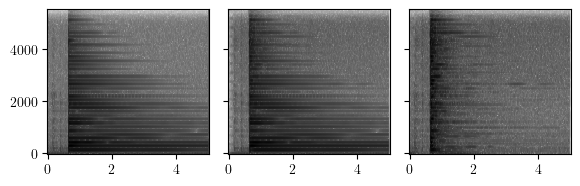

In [9]:
##Parameters
window_length = 512
hop_length = window_length//16
window_type = 'hann'
beta = .95
ester_factor = 50
max_poles = 25*window_length//64
## Checking Overlap Add Condition
#window = sig.get_window(window_type, window_length)
OLA_condition = sig.check_COLA(
    window = window_type,
    nperseg = window_length,
    noverlap = window_length-hop_length
)
print(f"Overlap add condition : {OLA_condition}")
##Computations

tic = time.time()
xWhitened, ARFilter = whiten_signal(
    x = x,
    n_fft = 512,
    rankFilter_bins = 200,
    rankFilter_rank = .3,
    ARFilter_length = 12,
)
start_idx = np.argmax(np.abs(sig.hilbert(x)))

num_poles, _ = ESTER(
    x = xWhitened,
    start_idx=start_idx,
    window_length=window_length,
    max_poles = max_poles,
    factor = ester_factor
)
print(f'Signal Order : {num_poles}')
#num_poles = 80
xChoppedWhitened = window_signal(
    x = xWhitened,
    window_length = window_length,
    hop_length = hop_length
)

xChopped = window_signal(
    x = x,
    window_length = window_length,
    hop_length = hop_length
)

xHarmo, xNoise = HN_FAPI(
    xChoppedWhitened = xChoppedWhitened,
    num_poles = num_poles,
    beta=beta,
    xChopped = xChopped,
    hop_length = hop_length,
    window_type = window_type)
toc = time.time()

print(f'Processing time : {round(toc-tic, 2)}s')

display(Audio(data = x, rate = sr_hz))
display(Audio(data = np.real(xHarmo), rate = sr_hz))
display(Audio(data = np.real(xNoise), rate = sr_hz))

fig, ax = plt.subplots(nrows= 1, ncols = 3, sharey = True, figsize = (15/cm, 5/cm))

f, t, x_stft = sig.stft(np.real(x), fs = sr_hz, return_onesided=True, scaling = 'psd')
ax[0].pcolormesh(t, f, dB10(x_stft), cmap = cmap, rasterized = True)
f, t, x_stft = sig.stft(np.real(xHarmo), fs = sr_hz, return_onesided=True, scaling = 'psd')
ax[1].pcolormesh(t, f, dB10(x_stft), cmap = cmap, rasterized = True)
f, t, x_stft = sig.stft(np.real(xNoise), fs = sr_hz, return_onesided=True, scaling = 'psd')
ax[2].pcolormesh(t, f, dB10(x_stft), cmap = cmap, rasterized = True)
plt.tight_layout()
plt.show()

## Filter Bank Design

In [43]:
def nearPR_CMFB(num_bands:int, num_taps:int = None, tol_transitionBand:float = None):
    """
    Returns near perfect reconstruction cosine-modulated filter bank
    impulse responses

    Parameters :
    ------------
    `num_bands` : int
        Number of bands in which the signal needs to be splitted
    `num_taps` : int
        Length of the filters, in samples
    `tol_transitionBand` : float
        Tolerance of the transition band of the filters

    Returns :
    ---------
    `filters` : array-like (num_bands, 10*num_bands-1)
        Impulse responses of the filters
    """
    # Number of filter taps
    if num_taps == None:
        num_taps = 10*num_bands-1
    # Width of the transition band
    if tol_transitionBand == None:
        tol_transitionBand = 1/(5*num_bands)

    # Design of the protoype filter
    prototype_filter_IR = sig.remez(
        numtaps = num_taps,
        bands = [
            0,
            1/(4*(num_bands-1)) - tol_transitionBand,
            1/(4*(num_bands-1)) + tol_transitionBand,
            1/2],
        fs = 1,
        type = 'bandpass',
        desired = [1, 0],
        weight= [1,1]
    )

    # Modulating the protoype filter to get the filter bank
    Analysis_filters = np.zeros((num_bands, num_taps))
    Synthesis_filters = np.zeros((num_bands, num_taps))
    for band_idx in range(num_bands):
        theta = np.power(-1, band_idx)*np.pi/4
        Analysis_filters[band_idx] = prototype_filter_IR*np.cos(
            np.pi*(np.arange(num_taps) - (num_taps)/2)*(band_idx+.5)/num_bands + theta
            ) *2
        Synthesis_filters[band_idx] = prototype_filter_IR*np.cos(
            np.pi*(np.arange(num_taps) - num_taps/2)*(band_idx+.5)/num_bands - theta
            ) *2
    return Analysis_filters, Synthesis_filters




In [170]:

num_bands = 4
num_taps = 16*num_bands-1
tol_transitionBand = 1/(np.power(num_bands, 1.8)-1)

x_test = np.zeros(2048)
x_test[0] = 1

Analysis_filters, Synthesis_filters = nearPR_CMFB(
    num_bands = num_bands,
    num_taps = num_taps,
    tol_transitionBand=tol_transitionBand)
## Plotting
save_folder = os.path.join(
    "..", "..", "PAM_overleaf", "Notes", "HR", "Preprocessing", "Figures")
n_fft = 2048
xRecons = np.zeros(len(x_test))

for band_idx in range(num_bands):
    xFilter = sig.lfilter(Analysis_filters[band_idx], [1], x_test)
    xInsert = np.zeros(len(x_test))
    xInsert[::num_bands] = xFilter[::num_bands]*num_bands
    xRecons+=sig.lfilter(Synthesis_filters[band_idx], [1], xInsert)


f = np.fft.rfftfreq(n_fft, 1)
plt.figure(figsize = figsize)
for band_idx in range(num_bands):
    plt.plot(f, dB20(np.fft.rfft(Analysis_filters[band_idx], n = n_fft)), '--')
plt.plot(f, dB20(np.fft.rfft(xRecons)), 'k', linewidth = 2)
plt.xlim(0,.5)
plt.ylim(-15, 5)
plt.ylabel('Amplitude [dB]')
plt.xlabel("Fréquence réduite")
plt.tight_layout()
plt.savefig(
    fname = os.path.join(save_folder, "filterBank.pdf"),
    bbox_inches = 'tight'
)
plt.show()


ValueError: Bands must be monotonic starting at zero.

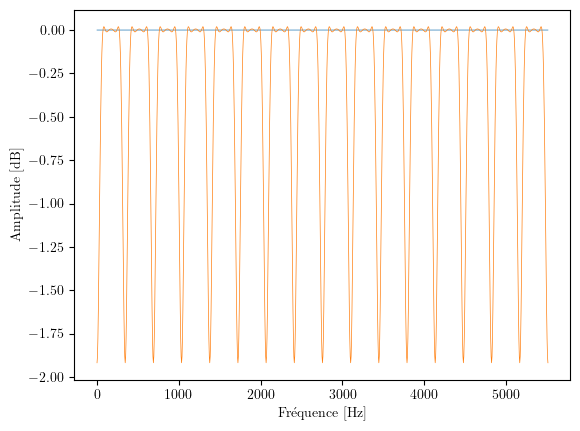

In [160]:


num_bands = 16
num_taps = 16*num_bands-1
tol_transitionBand = 2/(16*num_bands)

x_test = np.zeros(2048)
x_test[0] = 1

Analysis_filters, Synthesis_filters = nearPR_CMFB(
    num_bands = num_bands,
    num_taps = num_taps,
    tol_transitionBand=tol_transitionBand)
xRecons = np.zeros(len(x_test))

for band_idx in range(num_bands):
    xFilter = sig.lfilter(Analysis_filters[band_idx], [1], x_test)
    xInsert = np.zeros(len(x_test))
    xInsert[::num_bands] = xFilter[::num_bands]*num_bands
    xRecons+=sig.lfilter(Synthesis_filters[band_idx], [1], xInsert)

f = np.fft.rfftfreq(2048, 1/sr_hz)
plt.plot(f, dB20(np.fft.rfft(x_test)))
plt.plot(f, dB20(np.fft.rfft(xRecons)))
plt.xlabel("Fréquence [Hz]")
plt.ylabel("Amplitude [dB]")
plt.savefig('subband')
plt.show()
#plt.specgram(x, Fs = sr_hz)
#plt.show()
#plt.specgram(xRecons, Fs = sr_hz)
#plt.show()
display(Audio(data = x, rate = sr_hz))
display(Audio(data = xRecons, rate = sr_hz))


Signal Order : 4
Signal Order : 6
Signal Order : 5
Signal Order : 4
Signal Order : 10
Signal Order : 10
Signal Order : 10
Signal Order : 8
Signal Order : 4
Signal Order : 10
Signal Order : 8
Signal Order : 9
Signal Order : 2
Signal Order : 5
Signal Order : 2
Signal Order : 6
Processing time : 1.26s


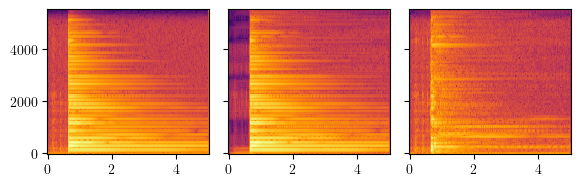

In [101]:
##Parameters
window_length = 32
hop_length = window_length//4
window_type = 'hann'
beta = .95
ester_factor = 10
max_poles = 25*window_length//64

num_bands = 16

## Initializing output vectors
xHarmo = np.zeros(len(x), dtype = np.complex128)
xNoise = np.zeros(len(x), dtype = np.complex128)

## Computations
tic = time.time()

## Filtering in sub bands
Analysis_filters, Synthesis_filters = nearPR_CMFB(num_bands = num_bands)
xFiltered = np.zeros((num_bands, len(x)))
for band_idx in range(num_bands):
    #xFiltered[band_idx]=x
    xFiltered[band_idx] = sig.lfilter(Analysis_filters[band_idx], [1], x)

xDecimated = xFiltered[:,::num_bands]

for band_idx in range(num_bands):
    xWhitened, ARFilter = whiten_signal(
        x = xDecimated[band_idx],
        n_fft = 512,
        rankFilter_bins = 300,
        rankFilter_rank = .3,
        ARFilter_length = 18,
    )
    start_idx = np.argmax(np.abs(sig.hilbert(xDecimated[band_idx])))

    num_poles, _ = ESTER(
        x = xWhitened,
        start_idx=start_idx,
        window_length=window_length,
        max_poles = max_poles,
        factor = ester_factor
    )
    num_poles+=0
    print(f'Signal Order : {num_poles}')
    #num_poles = 80
    xChoppedWhitened = window_signal(
        x = xWhitened,
        window_length = window_length,
        hop_length = hop_length
    )

    xChopped = window_signal(
        x = xDecimated[band_idx],
        window_length = window_length,
        hop_length = hop_length
    )

    xHarmo_band, xNoise_band = HN_FAPI(
        xChoppedWhitened = xChoppedWhitened,
        num_poles = num_poles,
        beta=beta,
        xChopped = xChopped,
        hop_length = hop_length,
        window_type = window_type)
    
    xHarmoInsert = np.zeros(len(x), dtype = np.complex128)
    xHarmoInsert[::num_bands] = xHarmo_band[:len(x)//num_bands+1]
    
    xNoiseInsert = np.zeros(len(x), dtype = np.complex128)
    xNoiseInsert[::num_bands] = xNoise_band[:len(x)//num_bands+1]

    xHarmo += sig.lfilter(Synthesis_filters[band_idx], [1], xHarmoInsert)*num_bands
    xNoise += sig.lfilter(Synthesis_filters[band_idx], [1], xNoiseInsert)*num_bands

toc = time.time()

print(f'Processing time : {round(toc-tic, 2)}s')

display(Audio(data = x, rate = sr_hz))
display(Audio(data = np.real(xHarmo), rate = sr_hz))
display(Audio(data = np.real(xNoise), rate = sr_hz))

fig, ax = plt.subplots(nrows= 1, ncols = 3, sharey = True, figsize = (15/cm, 5/cm))
cmap = 'inferno'
f, t, x_stft = sig.stft(np.real(x), fs = sr_hz, return_onesided=True, scaling = 'psd')
ax[0].pcolormesh(t, f, dB10(x_stft), cmap = cmap, rasterized = True)
f, t, x_stft = sig.stft(np.real(xHarmo), fs = sr_hz, return_onesided=True, scaling = 'psd')
ax[1].pcolormesh(t, f, dB10(x_stft), cmap = cmap, rasterized = True)
f, t, x_stft = sig.stft(np.real(xNoise), fs = sr_hz, return_onesided=True, scaling = 'psd')
ax[2].pcolormesh(t, f, dB10(x_stft), cmap = cmap, rasterized = True)
plt.tight_layout()
plt.show()

In [149]:
def multiband_HN(
    x,
    window_length:int = 32,
    hop_length:int = None,
    window_type:str = 'hann',
    ester_factor:int = 10,
    num_bands:int = 16, **kwargs):
    """
    Performs the full H+N decomposition using sub-band filtering, per band noise
    whitenening.
    Parameters :
    ------------
    `x` : array-like
        Input signal
    `window_length` : int
        Length of the windows used for the overlap-add method
    `ester_factor` : float
        used for he automatic pole number computation. The higher the factor is,
        the higher the number of poles used will be.
    `num_bands` : int
        number of frequency bands
    
    Returns :
    ---------
    `xHarmo` : array-like
        Projection of `x` onto the signal space
    `xNoise` : array-like
        Projection of `x` onto the noise space
    """
    
    # kwargs
    if hop_length==None:
        hop_length = window_length//4
    
    if "bandFilters_taps" in kwargs:
        bandFilters_taps = kwargs["bandFilters_taps"]
    else:
        bandFilters_taps = None
    
    if "bandFilters_tol" in kwargs:
        bandFilter_tol = kwargs["bandFilters_tol"]
    else:
        bandFilter_tol = None
    
    if "window_type" in kwargs:
        window_type = kwargs["window_type"]
    else:
        window_type = 'hann'
    
    if "tracking_method" in kwargs:
        tracking_method = kwargs["tracking_method"]
        if tracking_method=="FAPI":
            if "FAPI_beta" in kwargs:
                FAPI_beta = kwargs["FAPI_beta"]
            else:
                FAPI_beta = .95
    else:
        tracking_method = "classic"

    Analysis_filters, Synthesis_filters = nearPR_CMFB(
        num_bands = num_bands,
        num_taps = bandFilters_taps,
        tol_transitionBand = bandFilter_tol
    )


    max_poles = 25*window_length//64

    ## Initializing output vectors
    xHarmo = np.zeros(len(x), dtype = np.complex128)
    xNoise = np.zeros(len(x), dtype = np.complex128)
    for band_idx in range(num_bands):

        xDecimated = sig.lfilter(Analysis_filters[band_idx], [1], x)[::num_bands]

        start_idx = np.argmax(np.abs(sig.hilbert(xDecimated)))
        xWhitened, _ = whiten_signal(
            x = xDecimated,
            n_fft = 512,
            rankFilter_bins = 300,
            rankFilter_rank = .3,
            ARFilter_length = 12
        )
    
        num_poles, _ = ESTER(
            x = xDecimated,
            start_idx=start_idx,
            window_length=window_length,
            max_poles = max_poles,
            factor = ester_factor
        )
        xChoppedWhitened = window_signal(
            x = xDecimated,
            window_length = window_length,
            hop_length = hop_length
        )

        xChopped = window_signal(
            x = xDecimated,
            window_length = window_length,
            hop_length = hop_length
        )
        
        if tracking_method == "classic":
            xHarmo_band, xNoise_band = HN_ESPRIT(
                xChoppedWhitened = xChoppedWhitened,
                num_poles = num_poles,
                xChopped = xChopped,
                hop_length = hop_length,
                window_type = window_type)
        elif tracking_method == "FAPI":
            xHarmo_band, xNoise_band = HN_FAPI(
                xChoppedWhitened = xChoppedWhitened,
                num_poles = num_poles,
                xChopped = xChopped,
                hop_length = hop_length,
                beta = FAPI_beta,
                window_type = window_type)

        
        xHarmoInsert = np.zeros(len(x), dtype = np.complex128)
        xHarmoInsert[::num_bands] = xHarmo_band[:len(x)//num_bands+1]
        
        xNoiseInsert = np.zeros(len(x), dtype = np.complex128)
        xNoiseInsert[::num_bands] = xNoise_band[:len(x)//num_bands+1]

        xHarmo += sig.lfilter(Synthesis_filters[band_idx], [1], xHarmoInsert)*num_bands
        xNoise += sig.lfilter(Synthesis_filters[band_idx], [1], xNoiseInsert)*num_bands

    return xHarmo, xNoise
        
        


Processing time : 1.39s


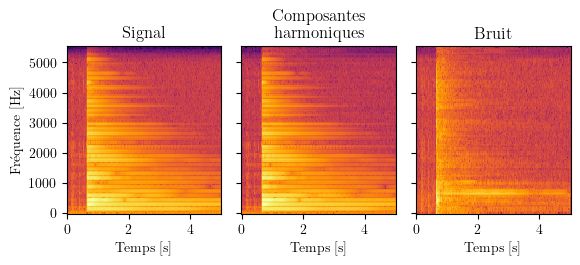

11025.0


In [155]:
##Parameters
window_length = 32
hop_length = 8
window_type = 'hann'
ester_factor = 20

num_bands = 16

## Initializing output vectors

## Computations
tic = time.time()
xHarmo, xNoise = multiband_HN(x, method = 'classic', num_bands = num_bands, ester_factor=50, window_length=window_length, hop_length=hop_length)

toc = time.time()

print(f'Processing time : {round(toc-tic, 2)}s')

display(Audio(data = x, rate = sr_hz))
display(Audio(data = np.real(xHarmo), rate = sr_hz))
display(Audio(data = np.real(xNoise), rate = sr_hz))

fig, ax = plt.subplots(nrows= 1, ncols = 3, sharey = True, figsize = (15/cm, 7/cm))
save_folder = os.path.join("HN", "Subspace", "Audio")
cmap = 'inferno'

f, t, x_stft = sig.stft(np.real(x), fs = sr_hz, return_onesided=True, scaling = 'psd')
ax[0].pcolormesh(t, f, dB10(x_stft), cmap = cmap, rasterized = True)
ax[0].set_title("Signal")
ax[0].set_ylabel("Fréquence [Hz]")
ax[0].set_xlabel("Temps [s]")
f, t, x_stft = sig.stft(np.real(xHarmo), fs = sr_hz, return_onesided=True, scaling = 'psd')
ax[1].pcolormesh(t, f, dB10(x_stft), cmap = cmap, rasterized = True)
ax[1].set_title("Composantes\nharmoniques")
ax[1].set_xlabel("Temps [s]")
f, t, x_stft = sig.stft(np.real(xNoise), fs = sr_hz, return_onesided=True, scaling = 'psd')
ax[2].pcolormesh(t, f, dB10(x_stft), cmap = cmap, rasterized = True)
ax[2].set_title("Bruit")
ax[2].set_xlabel("Temps [s]")
plt.tight_layout()

plt.savefig(os.path.join(save_folder, 'spectrogrammesHN.pdf'))
plt.show()

save_dict = {
    "input" : x,
    "harmonic" : xHarmo,
    "noise" : xNoise,
    "sampleRate" : sr_hz
}

with open("test_HN.pickle", "wb") as file:
    pickle.dump(save_dict, file, pickle.HIGHEST_PROTOCOL)

print(sr_hz)
scipy.io.wavfile.write(filename = os.path.join(save_folder, "input.wav"), rate = int(sr_hz), data = normalize(x))
scipy.io.wavfile.write(filename = os.path.join(save_folder, "input.wav"), rate = int(sr_hz), data = normalize(np.real(xHarmo)))
scipy.io.wavfile.write(filename = os.path.join(save_folder, "input.wav"), rate = int(sr_hz), data = normalize(np.real(xNoise)))

In [153]:
np.power(.99, 16)

0.8514577710948755